## Collect all .raw file names in the input_dir directory

In [1]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import datetime
import multiprocessing
import scipy.ndimage as ndimage
import copy

def get_dic_from_dir(input_dir):
	dic = {}
	raw_files = list(input_dir.glob("*.raw"))

	if not raw_files:
		print("No raw files found.")
		exit(1)

	is_first = True
	for raw_file in raw_files:
		#		  11111111112
		#012345678901234567890
		#IMG####_mmdd.HHMMSS.xxx.raw
		sequence = int(raw_file.stem[4:7])
		date_string = raw_file.stem[8:19]
		#print(f"Found raw file: {raw_file.name}, {sequence}, {date_string}")
		date_image = datetime.datetime.strptime(date_string, "%m%d.%H%M%S")

		if is_first:
			is_first = False
			date_first = date_image

		stamp = (date_image - date_first).total_seconds()
		dic[sequence] = {}
		dic[sequence]["raw_file"] = raw_file
		dic[sequence]["stamp"] = stamp
	
	return dic



## Plot mean, stddev and stddev/mean

In [2]:
def plot_mean(dic, keyname, ax):
	list_x = []
	list_y = []

	for sequence in sorted(dic.keys()):
		stamp = dic[sequence]["stamp"]
		array = dic[sequence]["xi"].dic[keyname]
		mean = array.mean()
		list_x.append(stamp)
		list_y.append(mean)

	ax.plot(list_x, list_y)
	ax.set_title("Mean")

def plot_std(dic, keyname, ax):
	list_x = []
	list_y = []

	for sequence in sorted(dic.keys()):
		stamp = dic[sequence]["stamp"]
		array = dic[sequence]["xi"].dic[keyname]
		std = array.std()
		list_x.append(stamp)
		list_y.append(std)

	ax.plot(list_x, list_y)

def plot_cv(dic, keyname, ax):
	list_x = []
	list_y = []

	for sequence in sorted(dic.keys()):
		stamp = dic[sequence]["stamp"]
		array = dic[sequence]["xi"].dic[keyname]
		cv = array.std() / array.mean()
		list_x.append(stamp)
		list_y.append(cv)

	ax.plot(list_x, list_y)



## Pairing of [low and high]

In [3]:

def get_paired(dic):
	dic_pair = {}
	for sequence in sorted(dic.keys()):
		if sequence % 2 == 0:
			if sequence -1 not in dic_pair:
				# Cannot pair
				return None
			else:
				dic_pair[sequence-1]["raw_file_high"] = dic[sequence]["raw_file"]
		else:
			dic_pair[sequence] = dic[sequence]
			dic_pair[sequence]["raw_file_low"] = dic[sequence]["raw_file"]
	return dic_pair

input_dir_off = pathlib.Path("data/250709/center_off").resolve()
input_dir_on = pathlib.Path("data/250709/center_on").resolve()
dic_off = get_dic_from_dir(input_dir_off)
dic_on = get_dic_from_dir(input_dir_on)
dic_off_pair = get_paired(dic_off)
dic_on_pair = get_paired(dic_on)


In [4]:
def show_distribution(array, title):
	plt.figure(figsize=(8, 4))
	plt.hist(array.ravel(), bins=1000, color='gray')
	plt.title(title)
	plt.xlabel('Pixel Intensity')
	plt.ylabel('Frequency')
	plt.grid(False)
	plt.show()

def show_distribution_log_scale(array, title):
	fig, ax = plt.subplots(figsize=(8, 4))
	ax.hist(array.ravel(), bins=1000, color='gray')
	ax.set_title(title)
	ax.set_xlabel('Pixel Intensity')
	ax.set_ylabel('Frequency')
	ax.set_yscale('log')
	ax.grid(False)
	plt.show()

def img_show(array, title):
	# Calculate mean along each axis
	mean_x_axis = np.mean(array, axis=0) # Mean along columns
	mean_y_axis = np.mean(array, axis=1) # Mean along rows

	# Create subplots
	fig, ax = plt.subplots(1, 3, figsize=(12, 4)) # One row, three columns

	# Plot the image
	im = ax[0].imshow(array, cmap='rainbow') # Display image in 'rainbow' colormap
	ax[0].set_title('Original Image')
	ax[0].set_xlabel('X-axis (Columns)')
	ax[0].set_ylabel('Y-axis (Rows)')
	fig.colorbar(im, ax=ax[0], orientation='vertical', label='Intensity')


	# Plot the mean along the X-axis
	ax[1].plot(mean_x_axis)
	ax[1].set_title('Mean along X-axis')
	ax[1].set_xlabel('X-axis (Columns)')
	ax[1].set_ylabel('Mean Intensity')

	# Plot the mean along the Y-axis
	ax[2].plot(mean_y_axis, range(len(mean_y_axis))) # Plot against y-axis indices
	ax[2].set_title('Mean along Y-axis')
	ax[2].set_xlabel('Mean Intensity')
	ax[2].set_ylabel('Y-axis (Rows)')
	ax[2].invert_yaxis() # Invert y-axis to match image orientation

	plt.suptitle(title, fontsize=16)
	plt.tight_layout()
	plt.show()



## Load into classes


In [5]:
import xintensity as xx

def make_manager_dict(d):
	"""Recursively turn a normal dict into one that lives in the manager."""
	md = manager.dict()
	for k, v in d.items():
		if isinstance(v, dict):
			md[k] = make_manager_dict(v)
		else:
			md[k] = v
	return md

def get_ratio_of_all(sequence):
	xi_off = xx.XIntensity()
	xi_off.read_raw_file_pair(shared_dic_off_pair[sequence]["raw_file_low"], shared_dic_off_pair[sequence]["raw_file_high"])
	xi_off.intensity_correction()
	xi_off.set_ratio(high="high_corrected", low="low_corrected")
	new_dic_off = dict(shared_dic_off_pair[sequence])
	new_dic_off["xi"] = copy.deepcopy(xi_off)
	shared_dic_off_pair[sequence] = new_dic_off

	xi_on = xx.XIntensity()
	xi_on.read_raw_file_pair(shared_dic_on_pair[sequence]["raw_file_low"], shared_dic_on_pair[sequence]["raw_file_high"])
	xi_on.dic["low_crop"] = xi_on.crop(xi_on.dic["low"])
	xi_on.dic["high_crop"] = xi_on.crop(xi_on.dic["high"])
	xi_on.set_ratio(high="high_crop", low="low_crop")
	new_dic_on = dict(shared_dic_on_pair[sequence])
	new_dic_on["xi"] = copy.deepcopy(xi_on)
	shared_dic_on_pair[sequence] = new_dic_on

	return

list_sequence = sorted(dic_off_pair.keys())
manager = multiprocessing.Manager()
shared_dic_off_pair = make_manager_dict(dic_off_pair)
shared_dic_on_pair = make_manager_dict(dic_on_pair)

list_pool_param = []
for sequence in list_sequence:
	tuple_param = (sequence, shared_dic_off_pair, shared_dic_on_pair)
	list_pool_param.append(tuple_param)

pool = multiprocessing.Pool()
#list_result = pool.starmap(get_ratio_of_all, list_pool_param)
list_result = pool.map(get_ratio_of_all, list_sequence)
pool.close()
pool.join()

#for sequence, result in zip(list_sequence, list_result):
#	dic_off_pair[sequence]["xi"] = copy.deepcopy(result[0])
#	dic_on_pair[sequence]["xi"] = copy.deepcopy(result[1])



[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79]


KeyError: 'high_corrected'

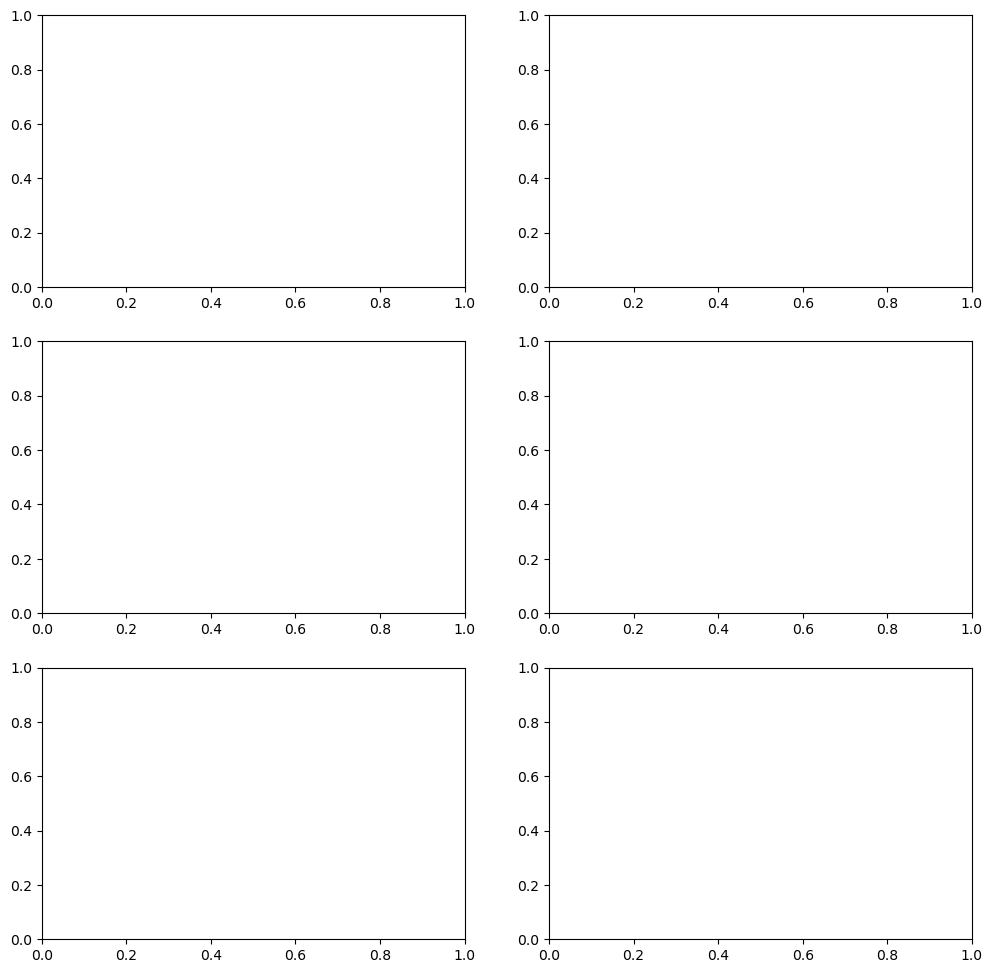

In [ ]:
print(list_sequence)
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
index_sample = 39
xi = shared_dic_off_pair[index_sample]["xi"]
xi.array_ratio
array_off_high = xi.dic["high_corrected"]

array_off_low = dic_off_pair[index_sample]["xi"].get_ratio()
array_off_ratio = dic_off_pair[index_sample]["xi"].dic["ratio"]
array_on_low = dic_on_pair[index_sample]["xi"].dic["low_crop"]
array_on_high = dic_on_pair[index_sample]["xi"].dic["high_crop"]
array_on_ratio = dic_on_pair[index_sample]["xi"].dic["ratio"]

plot_mean(dic_off_pair, "ratio", axs[0,0])

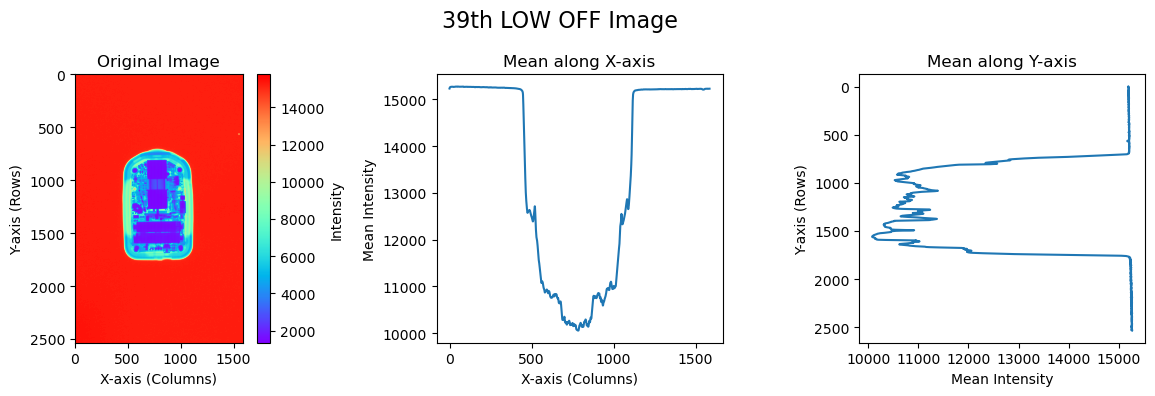

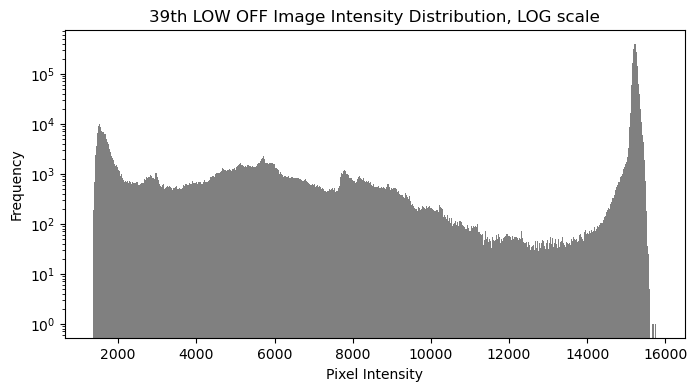

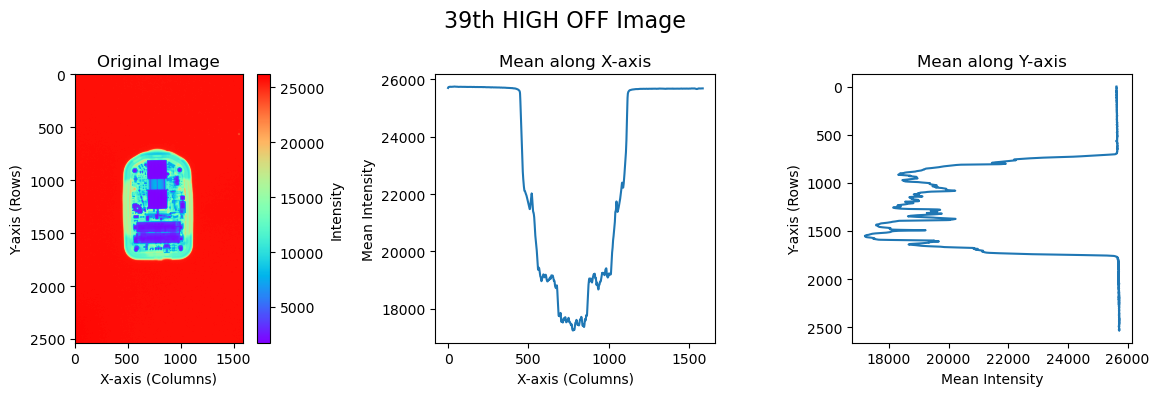

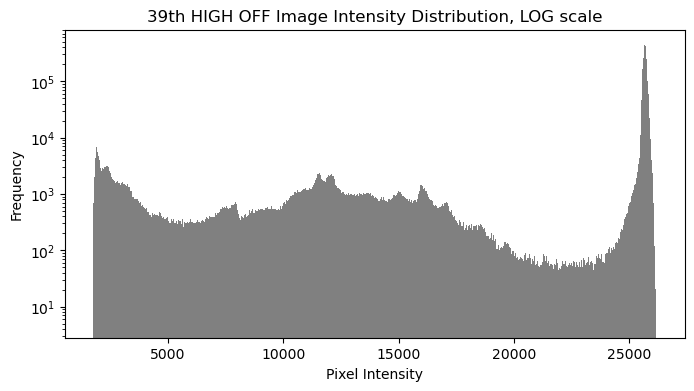

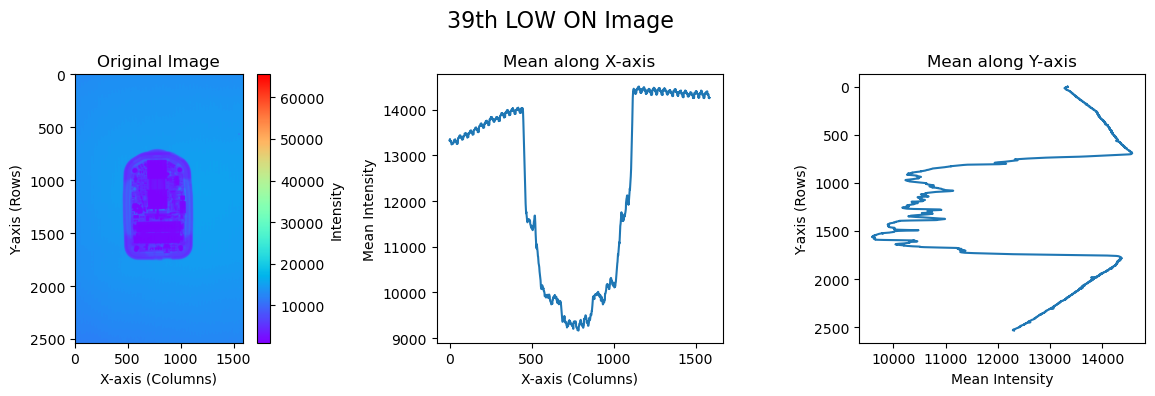

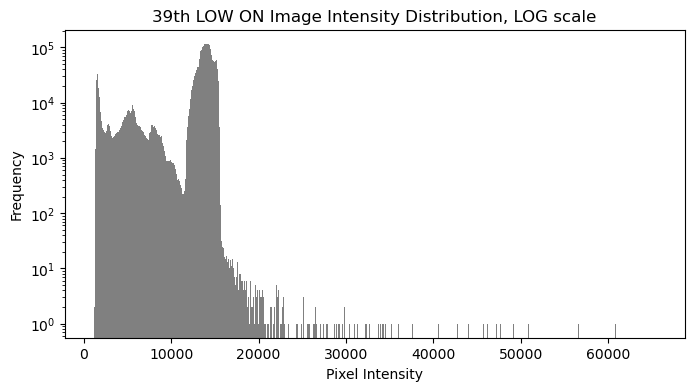

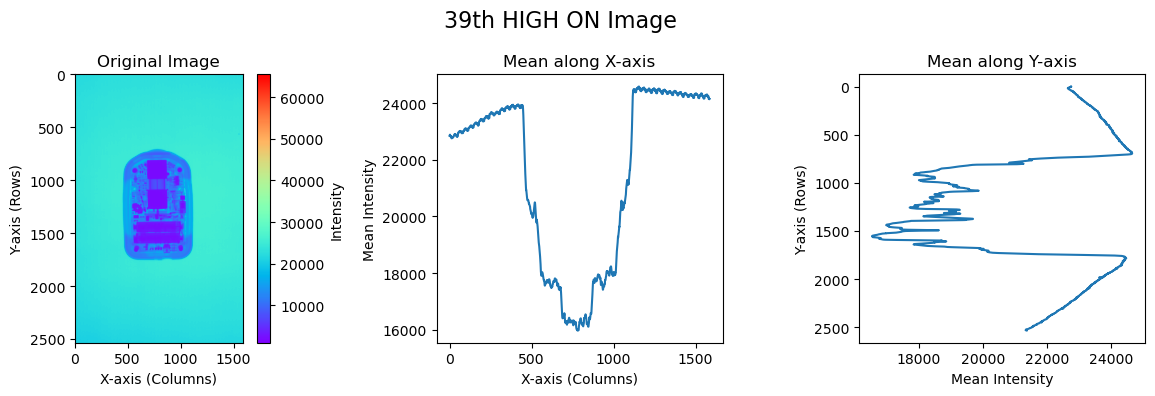

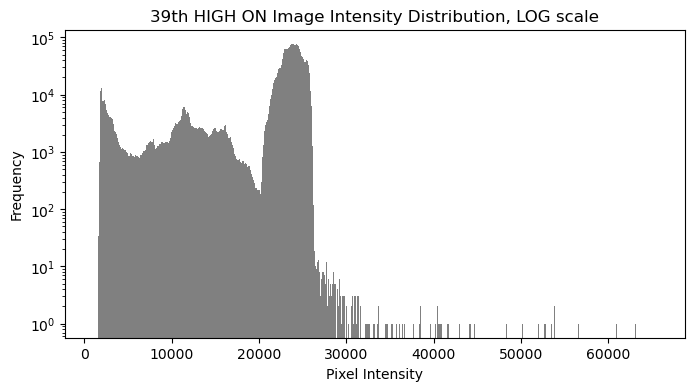

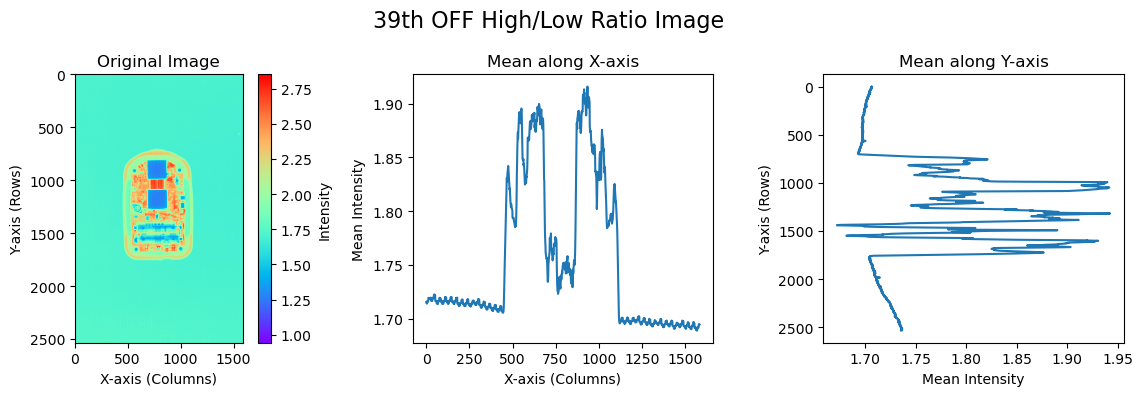

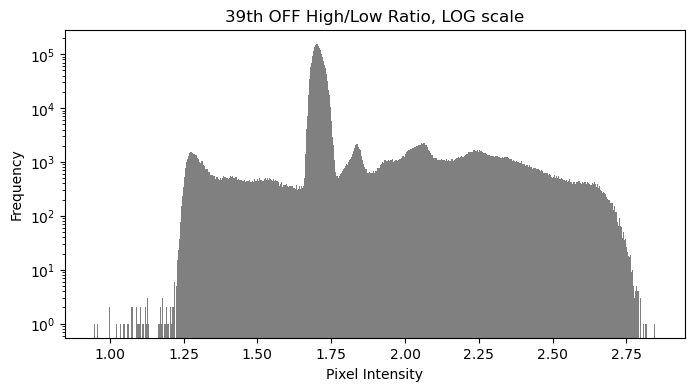

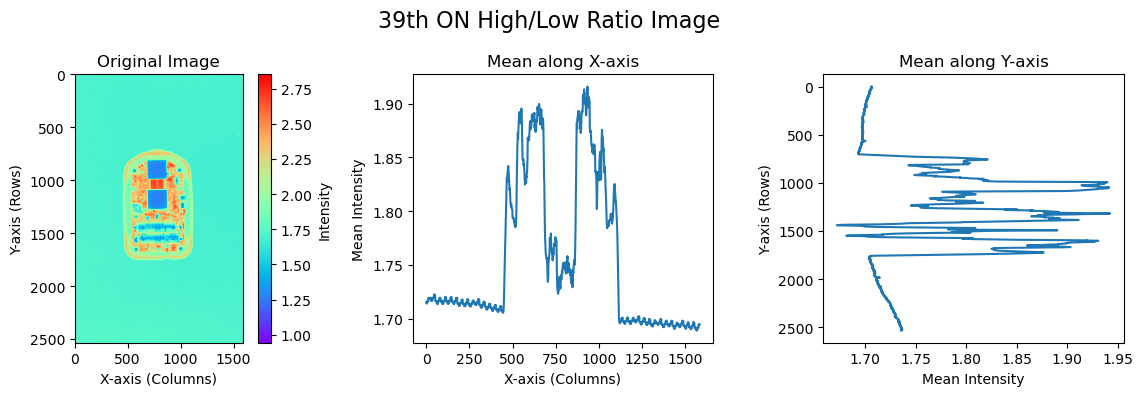

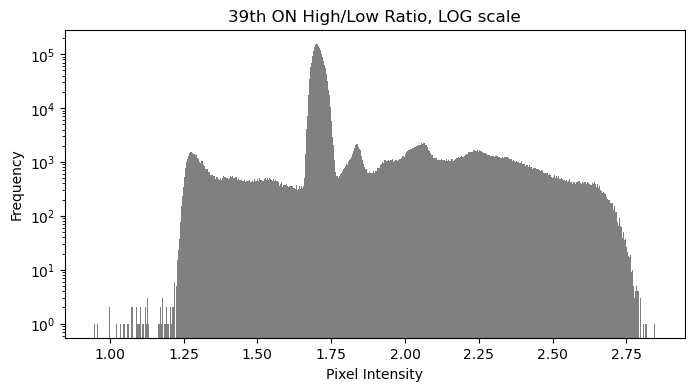

In [ ]:
index_sample = 39
array_off_low = dic_off_pair[index_sample]["xi"].dic["low_corrected"]
array_off_high = dic_off_pair[index_sample]["xi"].dic["high_corrected"]
array_off_ratio = dic_off_pair[index_sample]["xi"].get_ratio()
array_on_low = dic_on_pair[index_sample]["xi"].dic["low_crop"]
array_on_high = dic_on_pair[index_sample]["xi"].dic["high_crop"]
array_on_ratio = dic_on_pair[index_sample]["xi"].get_ratio()

img_show(array_off_low, f"{index_sample}th LOW OFF Image")
show_distribution_log_scale(array_off_low, f"{index_sample}th LOW OFF Image Intensity Distribution, LOG scale")

img_show(array_off_high, f"{index_sample}th HIGH OFF Image")
show_distribution_log_scale(array_off_high, f"{index_sample}th HIGH OFF Image Intensity Distribution, LOG scale")

img_show(array_on_low, f"{index_sample}th LOW ON Image")
show_distribution_log_scale(array_on_low, f"{index_sample}th LOW ON Image Intensity Distribution, LOG scale")

img_show(array_on_high, f"{index_sample}th HIGH ON Image")
show_distribution_log_scale(array_on_high, f"{index_sample}th HIGH ON Image Intensity Distribution, LOG scale")

img_show(array_off_ratio, f"{index_sample}th OFF High/Low Ratio Image")
show_distribution_log_scale(array_off_ratio, f"{index_sample}th OFF High/Low Ratio, LOG scale")

img_show(array_on_ratio, f"{index_sample}th ON High/Low Ratio Image")
show_distribution_log_scale(array_on_ratio, f"{index_sample}th ON High/Low Ratio, LOG scale")
